In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.utils import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score
from plot_learning_curve import plot_learning_curve, plot_validation_curve
import matplotlib.pyplot as plt
from sklearn import preprocessing

None


### Loading and Preprocessing Data

In [2]:
credit_train = pd.read_csv("credit-a.tsv", sep = "\t")
credit_train.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,target
0,2,156,0.000,2,1,13,8,1.25,1,1,1.0,0,0,42,0.0,0
1,1,328,4.460,2,1,11,4,3.04,1,1,6.0,0,0,118,560.0,0
2,1,89,0.500,2,1,11,4,1.50,1,0,0.0,0,0,74,824.0,0
3,2,125,1.540,2,1,13,8,3.75,1,1,5.0,1,0,1,3.0,0
4,2,43,5.625,2,1,13,8,1.71,1,0,0.0,0,2,8,0.0,0


In [3]:
credit_train = pd.get_dummies(credit_train, columns=['A1', 'A4', 'A5', 'A7', 'A9', 'A10', 'A12', 'A13'])
credit_train.shape

(690, 38)

In [4]:
normalize_columns = ['A2', 'A3', 'A6','A8', 'A11', 'A14']
def normalize(columns):
  scaler = preprocessing.StandardScaler()
  credit_train[columns] = scaler.fit_transform(credit_train[columns])
normalize(normalize_columns)

In [5]:
X = credit_train[[c for c in credit_train.columns if c != 'target']]
y = credit_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Trying Boosting Classifier without HyperParameter tunings

In [6]:
base_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [7]:
base_clf.fit(X_train, y_train)
y_train_pred = base_clf.predict(X_train)
y_test_pred = base_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  1.0
Test Accuracy:  0.8260869565217391


In [8]:
base_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

### Generate Learning Curve & Validation Curve with default classifier

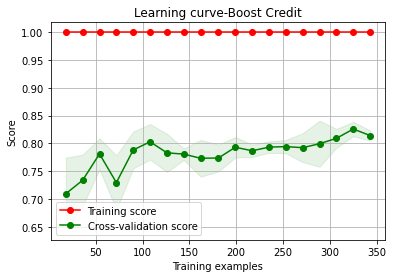

In [9]:
plot_learning_curve(base_clf, "Learning curve-Boost Credit", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

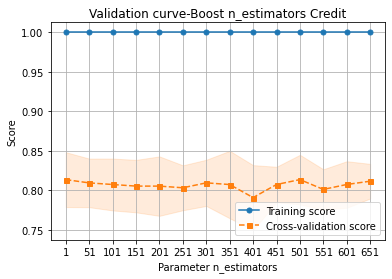

In [10]:
plot_validation_curve(base_clf, X_train, y_train, 'n_estimators', np.arange(1, 700, 50), cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-Boost n_estimators Credit")

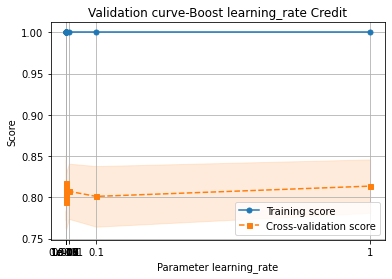

In [11]:
plot_validation_curve(base_clf, X_train, y_train, 'learning_rate', [0.0000000001, 0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-Boost learning_rate Credit")

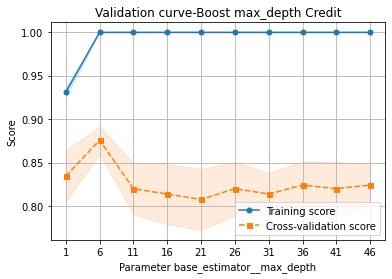

In [12]:
plot_validation_curve(base_clf, X_train, y_train, 'base_estimator__max_depth', np.arange(1, 50, 5), cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-Boost max_depth Credit")

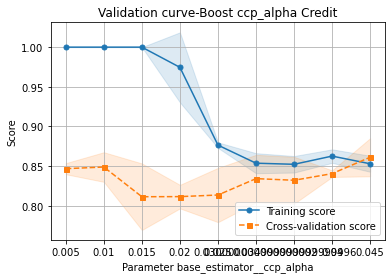

In [13]:
plot_validation_curve(base_clf, X_train, y_train, 'base_estimator__ccp_alpha', np.arange(0.005, 0.05, 0.005), cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-Boost ccp_alpha Credit")

### Conducting GridSearch to obtain best HyperParameters

In [14]:
param_grid = {
    'base_estimator__criterion': ['gini', 'entropy'],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
    'n_estimators': np.arange(100, 500, 50),
    'base_estimator__ccp_alpha': np.arange(0.005, 0.05, 0.005)
    #'base_estimator__max_depth': range(1,3)
}

In [15]:
grid_search = GridSearchCV(base_clf, param_grid= param_grid, cv=4, scoring=make_scorer(balanced_accuracy_score), verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 720 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

GridSearchCV(cv=4,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__ccp_alpha': array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045]),
                         'base_estimator__criterion': ['gini', 'entropy'],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
                         'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450])},
             scoring=make_scorer(balanced_accuracy_score), verbose=10)

In [16]:
df = pd.DataFrame(grid_search.cv_results_)
df.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__ccp_alpha,param_base_estimator__criterion,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
181,2.217587,0.136778,0.106726,0.001231,0.015,gini,0.01,350,"{'base_estimator__ccp_alpha': 0.015, 'base_est...",0.868021,0.868021,0.892206,0.876232,0.876120,0.009874,1
182,2.523235,0.154526,0.118312,0.001191,0.015,gini,0.01,400,"{'base_estimator__ccp_alpha': 0.015, 'base_est...",0.868021,0.868021,0.892206,0.876232,0.876120,0.009874,1
183,2.890687,0.160499,0.144619,0.016820,0.015,gini,0.01,450,"{'base_estimator__ccp_alpha': 0.015, 'base_est...",0.868021,0.868021,0.892206,0.876232,0.876120,0.009874,1
180,1.820630,0.139560,0.095374,0.004877,0.015,gini,0.01,300,"{'base_estimator__ccp_alpha': 0.015, 'base_est...",0.869818,0.868021,0.892206,0.866798,0.874211,0.010445,4
177,0.837914,0.011529,0.048620,0.001296,0.015,gini,0.01,150,"{'base_estimator__ccp_alpha': 0.015, 'base_est...",0.871614,0.869818,0.882946,0.866798,0.872794,0.006109,5


In [17]:
grid_search.best_params_

{'base_estimator__ccp_alpha': 0.015,
 'base_estimator__criterion': 'gini',
 'learning_rate': 0.01,
 'n_estimators': 350}

In [18]:
grid_search.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.015),
                   learning_rate=0.01, n_estimators=350)

In [19]:
grid_search.best_score_

0.8761199244865817

### Generating Learning Curve with tuned Hyperparameters

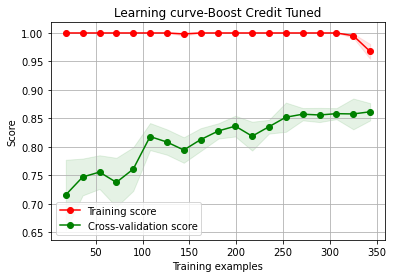

In [20]:
plot_learning_curve(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.015),
                   learning_rate=0.01, n_estimators=350), "Learning curve-Boost Credit Tuned", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

### Fitting classifier with best parameters and calculating test score

In [21]:
best_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.015),
                   learning_rate=0.01, n_estimators=350)
best_clf.fit(X_train, y_train)
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.8988979520999654
Test Accuracy:  0.8771739130434782
